# Libraries

In [2]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

In [78]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for index, filename in enumerate(files):

    if not index % 1000:
        print(index, " | ", end=" ")  # Counter
    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)  # Read file

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if tag.startswith("US "):
                    tag = tag[3:]  # Remove prefix
                if tag.endswith(" Corp"):
                    tag = tag[:-5]  # Remive postfix
                if tag.endswith(" Inc"):
                    tag = tag[:-4]  # Remive postfix
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

    except:
        continue  # In case of error

    articles.append(
        [year, title, url, list(set(subjects)), list(set(orgs)), list(set(people))]
    )

articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=['url']) # Remove articles with the same URL

articles.head(1)


0  |  1000  |  2000  |  3000  |  4000  |  5000  |  6000  |  7000  |  8000  |  9000  |  10000  |  11000  |  12000  |  13000  |  14000  |  15000  |  16000  |  17000  |  18000  |  19000  |  20000  |  21000  |  22000  |  23000  |  24000  |  25000  |  26000  |  

,year,title,url,subjects,orgs,people
0,2013,Two people rescued from house fire,http://www.bbc.co.uk/news/uk-wales-mid-wales-2...,"[rescues, fires and firefighters, fires and fi...",[],[]


In [80]:
entities = np.empty((0, 9), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [[entity, "subject", 1, years_template.copy(), [url], [title], co, None, None]],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)
            entities[index, 5][0].append(title)
            entities[index, 6][0] += co

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [[entity, "org", 1, years_template.copy(), [url], [title], co, None, None]],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)
            entities[index, 5][0].append(title)
            entities[index, 6][0] += co

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [[entity, "person", 1, years_template.copy(), [url], [title], co, None, None]],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)
            entities[index, 5][0].append(title)
            entities[index, 6][0] += co



entities = pd.DataFrame(
    entities,
    columns=["name", "type", "frequency", "years", "urls", "titles", "cooccurrences", "slope", "color"],
)  # Dataset

entities.to_csv("entities.csv", index=False)
entities.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color
5,energy and power,subject,1163,"{2011: 8, 2012: 12, 2013: 42, 2014: 33, 2015: ...",[http://www.staradvertiser.com/business/kauai-...,"[Kauai utility cuts its greenhouse emissions, ...","[electric light and power, light, air pollutio...",None,None


In [83]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color
23,Piyush Goyal,person,20,"{2011: 0, 2012: 0, 2013: 0, 2014: 2, 2015: 16,...",[http://economictimes.indiatimes.com/industry/...,[Need lab policy for renewable energy projects...,"[electric light and power, light, energy and p...",-0.121212,None


## Set colors

In [86]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = cmap(norm(row['slope']))

entities.sort_values(by=["slope"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color
5,energy and power,subject,1163,"{2011: 8, 2012: 12, 2013: 42, 2014: 33, 2015: ...",[http://www.staradvertiser.com/business/kauai-...,"[Kauai utility cuts its greenhouse emissions, ...","[electric light and power, light, air pollutio...",19.145455,"(0.705673158, 0.01555616, 0.150232812, 1.0)"


## Term Frequency

In [89]:
doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    entities['cooccurrences'].tolist(), tf_type="linear", idf_type="smooth"
)

dictionary


{'fires and firefighters': 1104,
 'fires and firemen': 1105,
 'animals': 1024,
 'dogs': 1083,
 'rescues': 1202,
 'agriculture': 1019,
 'arson': 1030,
 'Frances Wilmott': 320,
 'David Jones': 226,
 'frauds and swindling': 1117,
 'Niclas Parry': 690,
 'Richard Lewis Owen RHI': 813,
 'housing': 1140,
 'forests and forestry': 1116,
 'research': 1203,
 'global warming': 1126,
 'weather': 1256,
 'environment': 1095,
 'travel and vacations': 1242,
 'hotels and motels': 1139,
 'David Kimemia': 228,
 'Ashley Van Niekerk': 78,
 'energy and power': 1094,
 'recycling of waste materials': 1197,
 'waste materials and disposal': 1253,
 'flowers and plants': 1110,
 'food': 1111,
 'farmers': 1101,
 'John Kozij': 464,
 'electric light and power': 1092,
 'light': 1158,
 'accidents and safety': 1015,
 'explosions': 1099,
 'trees and shrubs': 1243,
 'editorials': 1089,
 'Devi Lal': 246,
 'Paddy straw laden': 714,
 'Keith Trotter': 527,
 'air pollution': 1020,
 'R Butler': 769,
 'finances': 1103,
 'Upendra 

## UMAP

In [ ]:
# reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=2, min_dist=.1, metric='cosine')
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=10, min_dist=0.001, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
# embedding = align_points_to_grid(embedding)
x = embedding[:, 0]
y = embedding[:, 1]


## Clustering

In [ ]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.5)
# clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters


clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values:
    values.remove(-1)

clusters = [
    [index for index, cluster in enumerate(clusters) if cluster == value]
    for value in values
]

len(clusters)


11

# Plotting

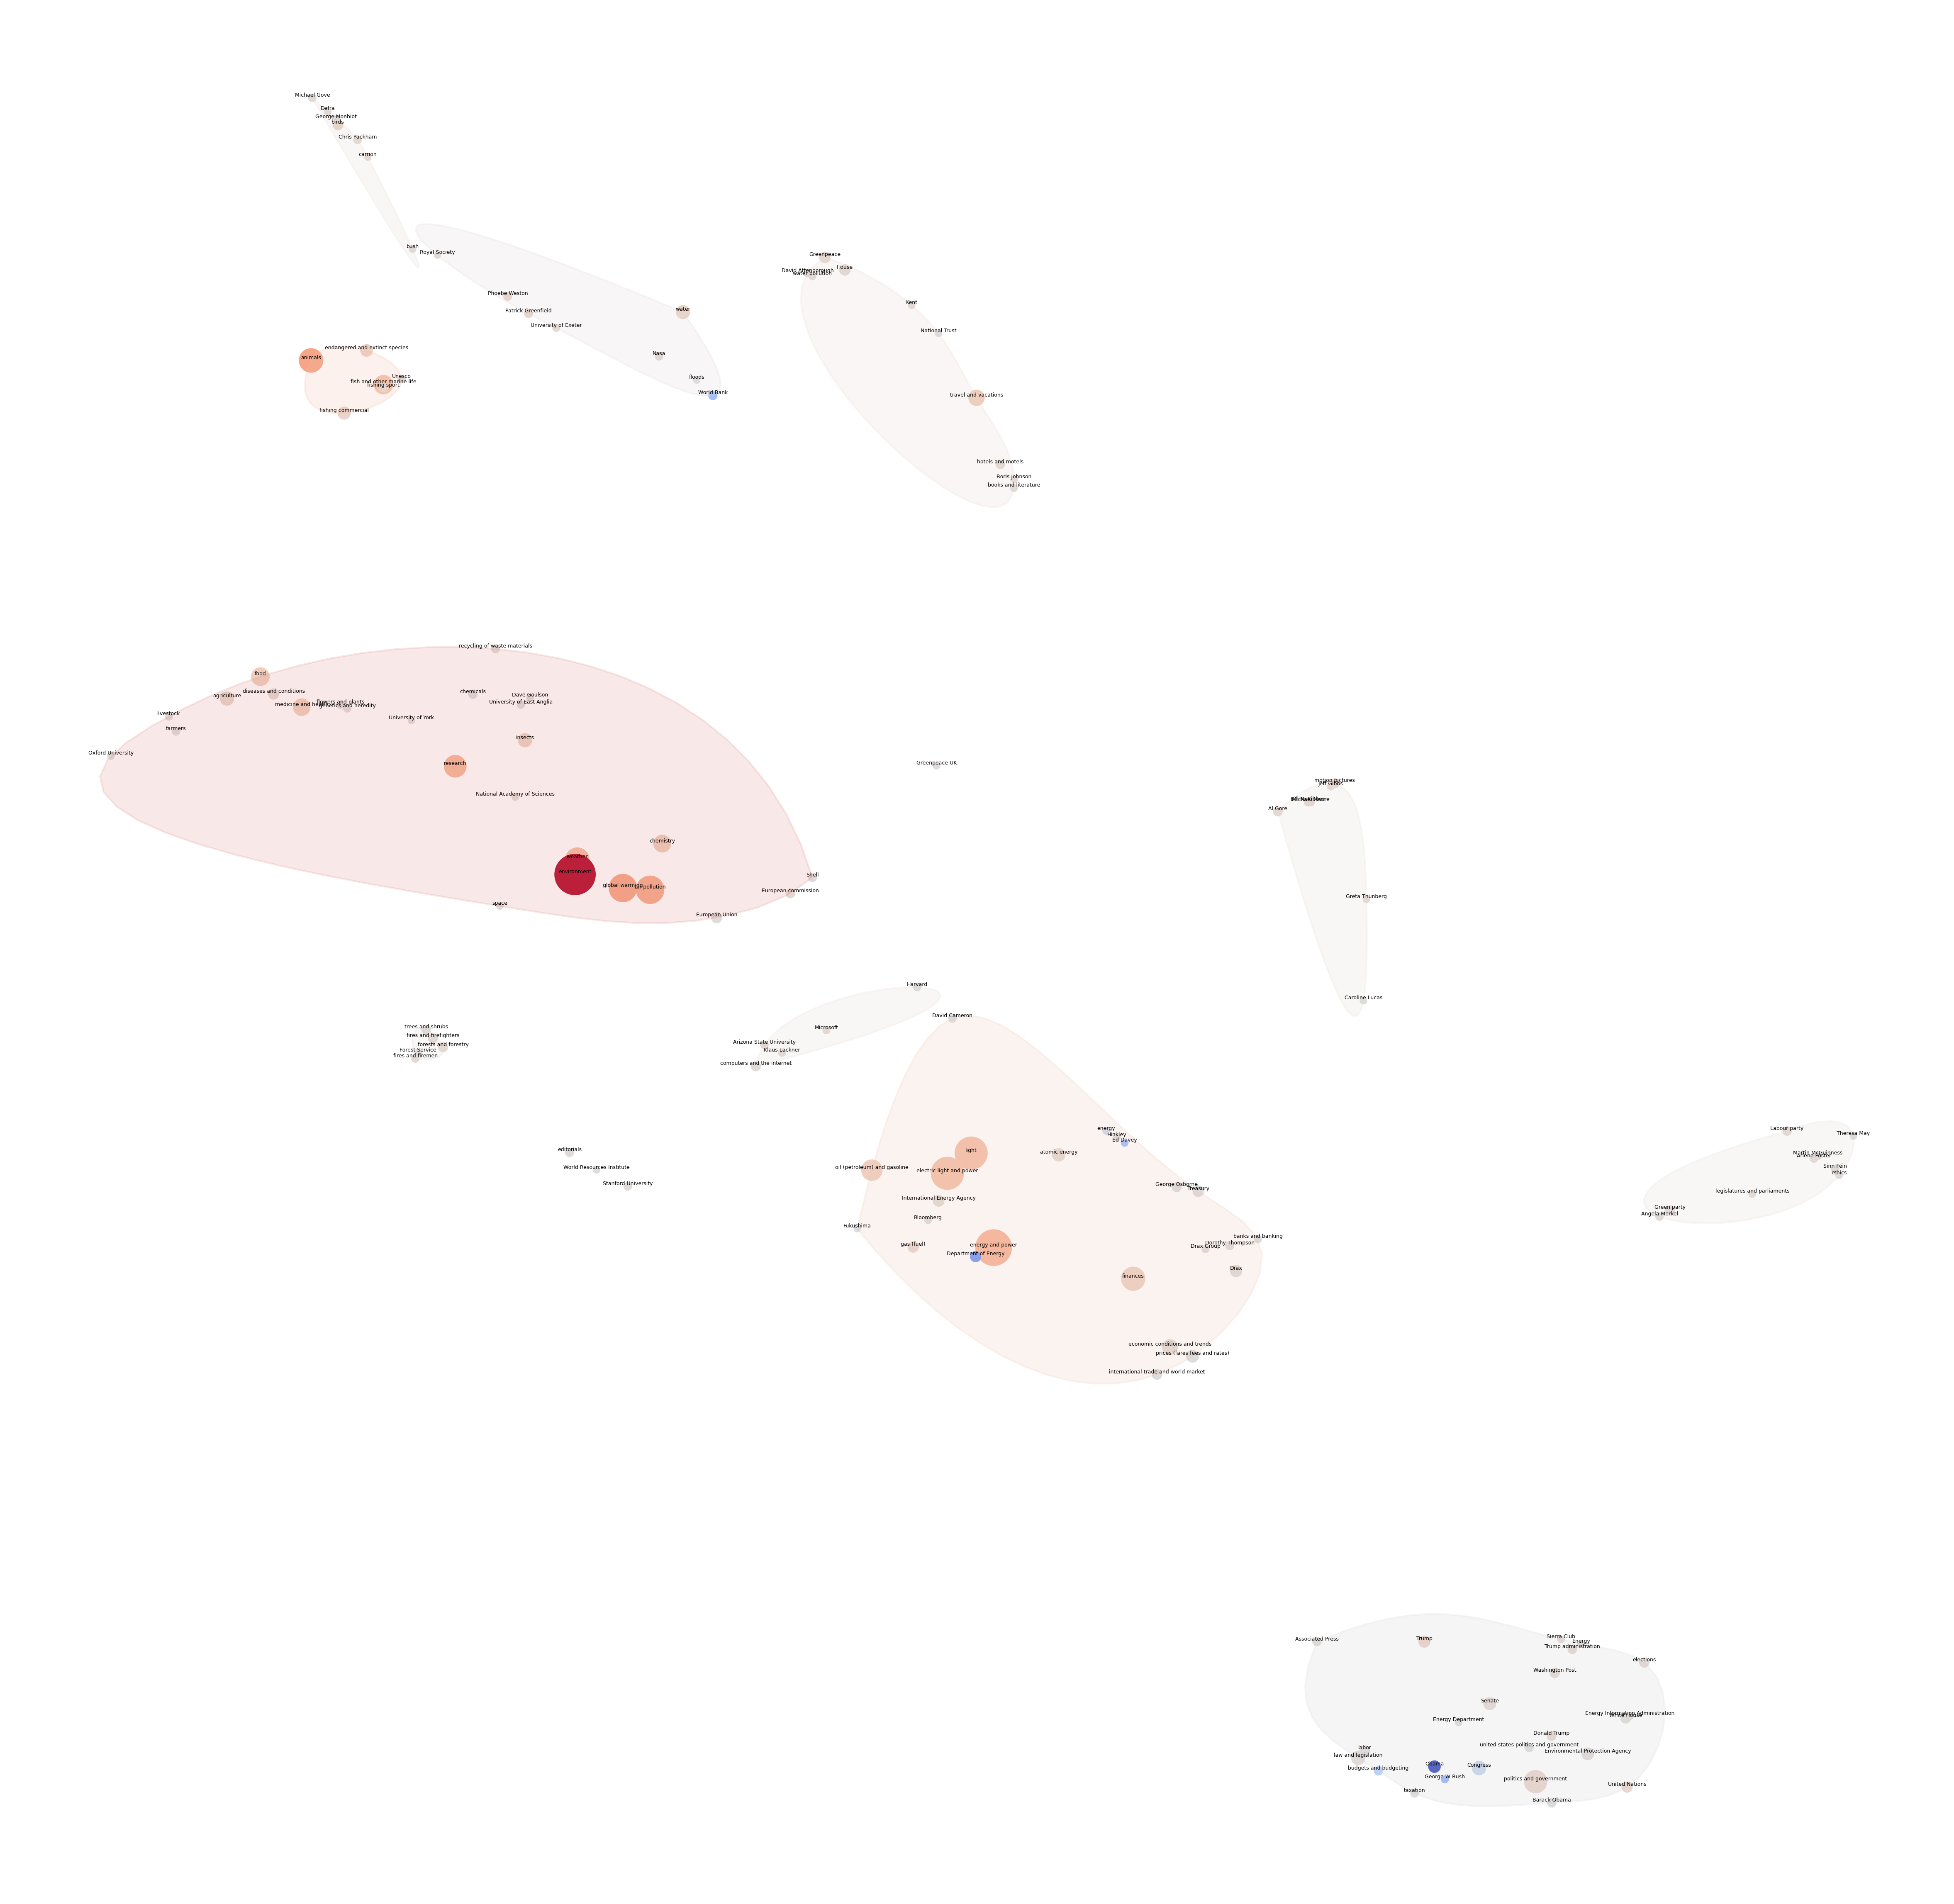

In [ ]:
# Frame

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")


# Hulls

for cluster in clusters:

    # Average color

    background_color = []

    for i, index in enumerate(cluster):
        for occurence in range(occurences[index]):
            background_color.append(
                [colors[index][0], colors[index][1], colors[index][2]]
            )

    r = [i[0] for i in background_color]
    r = sum(r) / len(r)
    g = [i[1] for i in background_color]
    g = sum(g) / len(g)
    b = [i[2] for i in background_color]
    b = sum(b) / len(b)

    background_color = (r, g, b, 1)

    # Hull

    points = []
    for index in cluster:
        points.append([embedding[index][0], embedding[index][1]])
    points = np.array(points)

    # print(points)

    hull = ConvexHull(points)

    x_hull = np.append(
        points[hull.vertices, 0], points[hull.vertices, 0][0]
    )  # Collect the xs + first x
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    # print(x_hull)

    # break

    # Interpolation

    dist = np.sqrt((x_hull[:-1] - x_hull[1:]) ** 2 + (y_hull[:-1] - y_hull[1:]) ** 2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)

    # plot shape
    plt.fill(interp_x, interp_y, "--", c=background_color, alpha=0.2)


# Scatterplot

plt.scatter(x, y, s=occurences, c=colors)
# plt.scatter(x, y, s=40, c=colors)


# Labels

for i, txt in enumerate(orgs):
    # text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(occurences[i]/math.pi)/40), ha='center', va='bottom')
    text = plt.annotate(orgs[i], xy=(x[i], y[i]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


# Saving files

In [ ]:
# JSONs

with open("src/data/frequencies.json", "w", encoding="UTF8") as file:
    json.dump(years, file)

with open("src/data/urls.json", "w", encoding="UTF8") as file:
    json.dump(urls, file)


# CSVs

with open("src/data/clusters.csv", "w", encoding="UTF8") as file:
    file.write("cluster\n")
    for indexEmbedding, element in enumerate(embedding):
        value = None
        for indexCluster, cluster in enumerate(clusters):
            if indexEmbedding in cluster:
                value = indexCluster
        file.write(str(value) + "\n")

with open("src/data/embedding.csv", "w", encoding="UTF8") as f:
    f.write("x,y\n")
    for element in embedding:
        f.write(str(element[0]) + "," + "-" + str(element[1]) + "\n")

with open("src/data/occurrences.csv", "w", encoding="UTF8") as f:
    f.write("occurrence\n")
    for element in occurences:
        f.write(str(element) + "\n")

with open("src/data/names.csv", "w", encoding="UTF8") as f:
    f.write("name\n")
    for element in orgs:
        f.write(str(element) + "\n")

with open("src/data/regressions.csv", "w", encoding="UTF8") as f:
    f.write("regression\n")
    for element in slopes:
        f.write(str(element) + "\n")
